<a href="https://colab.research.google.com/github/SkyTong/DS440/blob/main/Expr17_LSTM_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Conv1D, Input

#np.set_printoptions(threshold=np.inf)

# Load the dataset

In [82]:
org_df = pd.read_csv('/content/processed_hourly_data.csv',index_col=0)

In [83]:
org_df

,Datetime,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,Nikkei225,...,total_volume_quote,total_volume_base,total_volume_total,volume,high,low,open,close,volumefrom,volumeto
667,2022-02-28 10:00:00-05:00,4360.924805,33767.826172,3915.540039,13709.718262,95.510002,3457.902100,1910.400024,30.559999,26522.330078,...,4.074564e+08,8.501518e+09,8.908974e+09,100298.59,40917.71,39652.14,39849.29,40845.79,7495.87,3.026021e+08
668,2022-02-28 11:00:00-05:00,4369.179932,33849.894531,3933.479980,13734.242676,95.440002,3457.902100,1894.500000,28.690001,26522.330078,...,2.951618e+08,7.640820e+09,7.935982e+09,71235.25,41338.07,40736.36,40845.79,41021.81,5232.77,2.148198e+08
669,2022-02-28 12:00:00-05:00,4349.699951,33720.744141,3933.479980,13666.251465,96.209999,3457.902100,1900.900024,30.639999,26522.330078,...,2.022620e+08,6.928419e+09,7.130681e+09,40264.68,41320.14,40768.17,41021.81,41319.61,2842.60,1.165622e+08
670,2022-02-28 13:00:00-05:00,4332.359863,33589.654297,3933.479980,13607.824707,96.459999,3457.902100,1900.699951,30.820000,26522.330078,...,1.731512e+08,6.676633e+09,6.849784e+09,34319.26,41427.99,41082.37,41319.61,41217.44,2455.10,1.013162e+08
671,2022-02-28 14:00:00-05:00,4331.229980,33588.664062,3933.479980,13605.203125,95.680000,3457.902100,1908.300049,31.920000,26522.330078,...,1.655895e+08,5.810772e+09,5.976362e+09,28324.04,41377.67,41057.84,41217.44,41357.77,2007.00,8.271987e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18064,2024-02-20 11:00:00-05:00,4969.645020,38550.503906,4763.259766,15567.405273,78.860001,2920.561279,2038.500000,15.580000,38409.390625,...,1.727552e+09,1.730651e+09,3.458204e+09,33578.32,51795.47,51369.97,51693.91,51396.39,1748.02,9.020375e+07
18065,2024-02-20 12:00:00-05:00,4961.074951,38504.060547,4763.259766,15532.355957,79.169998,2920.561279,2040.000000,15.640000,38409.390625,...,3.983693e+08,3.721585e+09,4.119954e+09,44409.48,51397.71,50766.77,51396.39,51321.90,3702.71,1.892794e+08
18066,2024-02-20 13:00:00-05:00,4965.669922,38540.031250,4763.259766,15555.064941,79.230003,2920.561279,2038.599976,15.500000,38409.390625,...,1.272772e+08,1.996156e+09,2.123433e+09,22321.76,51536.57,51236.14,51321.90,51504.22,1518.03,7.796947e+07
18067,2024-02-20 14:00:00-05:00,4973.215088,38575.441406,4763.259766,15592.756348,78.269997,2920.561279,2036.500000,15.330000,38409.390625,...,2.904525e+08,2.182250e+09,2.472703e+09,28053.63,52111.16,51439.74,51504.22,52095.65,1791.37,9.274488e+07


In [84]:
org_df.columns

Index(['Datetime', 'SP500', 'DOW30', 'EuroStoxx50', 'NASDAQ', 'CrudeOil',
       'SSE', 'Gold', 'VIX', 'Nikkei225', 'FTSE100', 'EURUSD', 'CNYUSD',
       'GBPUSD', 'JPYUSD', 'CHFUSD', 'top_tier_volume_quote',
       'top_tier_volume_base', 'top_tier_volume_total', 'cccagg_volume_quote',
       'cccagg_volume_base', 'cccagg_volume_total', 'total_volume_quote',
       'total_volume_base', 'total_volume_total', 'volume', 'high', 'low',
       'open', 'close', 'volumefrom', 'volumeto'],
      dtype='object')

# Features engineering

In [85]:
org_df

,Datetime,SP500,DOW30,EuroStoxx50,NASDAQ,CrudeOil,SSE,Gold,VIX,Nikkei225,...,total_volume_quote,total_volume_base,total_volume_total,volume,high,low,open,close,volumefrom,volumeto
667,2022-02-28 10:00:00-05:00,4360.924805,33767.826172,3915.540039,13709.718262,95.510002,3457.902100,1910.400024,30.559999,26522.330078,...,4.074564e+08,8.501518e+09,8.908974e+09,100298.59,40917.71,39652.14,39849.29,40845.79,7495.87,3.026021e+08
668,2022-02-28 11:00:00-05:00,4369.179932,33849.894531,3933.479980,13734.242676,95.440002,3457.902100,1894.500000,28.690001,26522.330078,...,2.951618e+08,7.640820e+09,7.935982e+09,71235.25,41338.07,40736.36,40845.79,41021.81,5232.77,2.148198e+08
669,2022-02-28 12:00:00-05:00,4349.699951,33720.744141,3933.479980,13666.251465,96.209999,3457.902100,1900.900024,30.639999,26522.330078,...,2.022620e+08,6.928419e+09,7.130681e+09,40264.68,41320.14,40768.17,41021.81,41319.61,2842.60,1.165622e+08
670,2022-02-28 13:00:00-05:00,4332.359863,33589.654297,3933.479980,13607.824707,96.459999,3457.902100,1900.699951,30.820000,26522.330078,...,1.731512e+08,6.676633e+09,6.849784e+09,34319.26,41427.99,41082.37,41319.61,41217.44,2455.10,1.013162e+08
671,2022-02-28 14:00:00-05:00,4331.229980,33588.664062,3933.479980,13605.203125,95.680000,3457.902100,1908.300049,31.920000,26522.330078,...,1.655895e+08,5.810772e+09,5.976362e+09,28324.04,41377.67,41057.84,41217.44,41357.77,2007.00,8.271987e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18064,2024-02-20 11:00:00-05:00,4969.645020,38550.503906,4763.259766,15567.405273,78.860001,2920.561279,2038.500000,15.580000,38409.390625,...,1.727552e+09,1.730651e+09,3.458204e+09,33578.32,51795.47,51369.97,51693.91,51396.39,1748.02,9.020375e+07
18065,2024-02-20 12:00:00-05:00,4961.074951,38504.060547,4763.259766,15532.355957,79.169998,2920.561279,2040.000000,15.640000,38409.390625,...,3.983693e+08,3.721585e+09,4.119954e+09,44409.48,51397.71,50766.77,51396.39,51321.90,3702.71,1.892794e+08
18066,2024-02-20 13:00:00-05:00,4965.669922,38540.031250,4763.259766,15555.064941,79.230003,2920.561279,2038.599976,15.500000,38409.390625,...,1.272772e+08,1.996156e+09,2.123433e+09,22321.76,51536.57,51236.14,51321.90,51504.22,1518.03,7.796947e+07
18067,2024-02-20 14:00:00-05:00,4973.215088,38575.441406,4763.259766,15592.756348,78.269997,2920.561279,2036.500000,15.330000,38409.390625,...,2.904525e+08,2.182250e+09,2.472703e+09,28053.63,52111.16,51439.74,51504.22,52095.65,1791.37,9.274488e+07


In [86]:


# Remove the first column
#org_df = org_df.drop(org_df.columns[0], axis=1)

# Now org_df will have the first column removed
#org_df


In [87]:
import pandas as pd

# Assuming your DataFrame is called org_df

# Convert 'Datetime' column to datetime data type
org_df['Datetime'] = pd.to_datetime(org_df['Datetime'])

# Set 'Datetime' column as the index
org_df.set_index('Datetime', inplace=True)

# Now 'Datetime' column should be the index of the DataFrame
# Check the data type of the index
print("Data type of elements in the index:", org_df.index.dtype)

# Check the data types of all columns again
print("\nData types of all columns:")
print(org_df.dtypes)

Data type of elements in the index: datetime64[ns, UTC-05:00]

Data types of all columns:
SP500                    float64
DOW30                    float64
EuroStoxx50              float64
NASDAQ                   float64
CrudeOil                 float64
SSE                      float64
Gold                     float64
VIX                      float64
Nikkei225                float64
FTSE100                  float64
EURUSD                   float64
CNYUSD                   float64
GBPUSD                   float64
JPYUSD                   float64
CHFUSD                   float64
top_tier_volume_quote    float64
top_tier_volume_base     float64
top_tier_volume_total    float64
cccagg_volume_quote      float64
cccagg_volume_base       float64
cccagg_volume_total      float64
total_volume_quote       float64
total_volume_base        float64
total_volume_total       float64
volume                   float64
high                     float64
low                      float64
open               

# Dataset scalling

In [88]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 31


# Configuration

In [89]:
expr_name = 'expr_17'
look_back = 40 # 60 days, as each entry is for 1 hour
lstm_layers = 32
epochs=10
batch_size=32

# spliting datasets into train and test

In [90]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  9957
Testing dataset length  2490
look_back  40


# Build the model and train

In [91]:
trainX.shape

(9916, 40, 31)

In [92]:
# create and fit the LSTM network

input_layer = Input(shape=(look_back,num_of_features))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
lstm1 = LSTM(lstm_layers)(conv1)
output_layer = Dense(1, activation='sigmoid')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40, 31)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 40, 32)            7968      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16321 (63.75 KB)
Trainable params: 16321 (63.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/10
217/217 [==============================] - 9s 30ms/step - loss: 0.0072 - val_loss: 0.0054
Epoch 2/10
217/217 [==============================] - 5s 22ms/step - loss: 0.0103 - val_loss: 0.0125
Epoch 3/10
217/217 [==============================] - 6s 28ms/step - loss: 0.0263 - val_loss: 0.0190
Epoch 4/10
217/217 [==============================] - 5s 22ms/step - loss: 0.0319 - val_loss: 0.0057
Epoch 5/10
217/217 [==============================] - 5s 22ms/step - loss: 0.0206 - val_loss: 0.0011
Epoch 6/10
217/217 [==============================] - 6s 27ms/step - loss: 0.0119 - val_loss: 0.0028
Epoch 7/10
217/217 [==============================] - 5s 22ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 8/10
217/217 [==============================] - 6s 28ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 9/10
217/217 [==============================] - 5s 22ms/step - loss: 0.0034 - val_loss: 9.6496e-04
Epoch 10/10
217/217 [==============================] - 6s 26ms/step - loss: 0.0027 - va

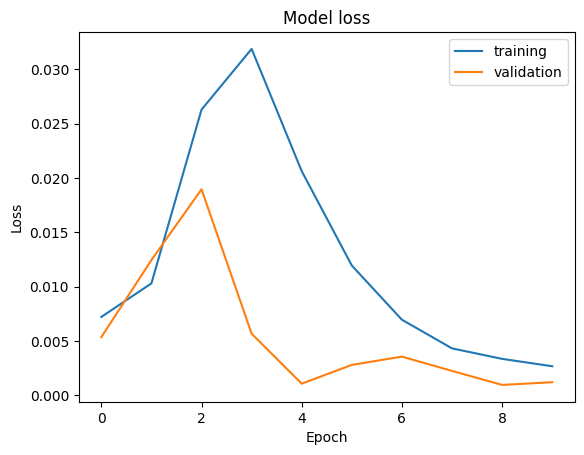

In [94]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [95]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col]

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

77/77 [==============================] - 1s 7ms/step


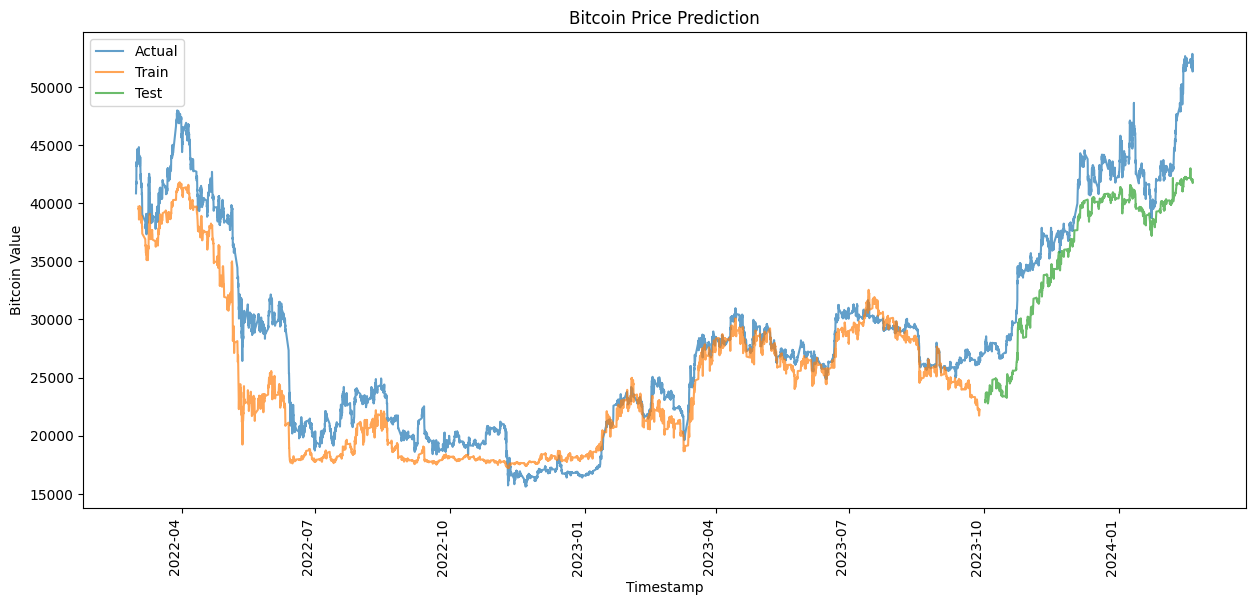

In [97]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('Datetime',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [98]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_17
--------------------------------------------------
look_back days: 1.6666666666666667
lstm_layers: 32
epochs: 10
batch_size: 32
dataset features ['SP500', 'DOW30', 'EuroStoxx50', 'NASDAQ', 'CrudeOil', 'SSE', 'Gold', 'VIX', 'Nikkei225', 'FTSE100', 'EURUSD', 'CNYUSD', 'GBPUSD', 'JPYUSD', 'CHFUSD', 'top_tier_volume_quote', 'top_tier_volume_base', 'top_tier_volume_total', 'cccagg_volume_quote', 'cccagg_volume_base', 'cccagg_volume_total', 'total_volume_quote', 'total_volume_base', 'total_volume_total', 'volume', 'high', 'low', 'open', 'close', 'volumefrom', 'volumeto']
--------------------------------------------------
Train Score: 2754.95 RMSE
Test Score: 4030.81 RMSE
--------------------------------------------------
Train Score: 2082.87 MAE
Test Score: 3577.61 MAE
--------------------------------------------------
Model summary:
Model: "model_4"
_________________________________________________________________
 